In [143]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import auc, roc_curve, roc_auc_score , accuracy_score, mean_squared_error, f1_score, r2_score

from scipy.stats import stats 
from scipy.stats import chi2_contingency



In [86]:
df = pd.read_csv('C:/Users/82108/Notebook/EP_2_data/m1.csv')
df.head() 

,노선ID,버스ID,정류장ID,일시,인원수,승객타입,행동타입
0,노선1,VEM7J0rb5O,1,2025-01-01 05:00:00,0,청소년,탑승
1,노선1,VEM7J0rb5O,2,2025-01-01 05:03:57,0,청소년,탑승
2,노선1,VEM7J0rb5O,3,2025-01-01 05:07:09,0,청소년,탑승
3,노선1,VEM7J0rb5O,4,2025-01-01 05:16:28,0,청소년,탑승
4,노선1,VEM7J0rb5O,5,2025-01-01 05:21:48,0,청소년,탑승


✅ 1. 전처리 
1. 승객타입 컬럼의 unique value들을 컬럼으로 만들고 인원수를 value로 삽입하라. 결측치가 있다면 0으로 만든다
2. 노선ID,버스ID,정류장ID,일시에 대해 누적청소년,누적성인,누적노인 인원수 컬럼을 생성하라.
3. 노선ID,버스ID,정류장ID,일시에 대해 누적수익 컬럼을 만들고 누적 수익금액을 계산하라
4. 정류장간 이동시간 컬럼(초단위)을 생성하라. 첫번째 정류장까지의 이동시간은 31초로 고정이다.
5. 날짜 관련한 파생변수를 3개 추가

In [87]:
# 1) 
pivot = df.pivot_table(index = ['노선ID','버스ID','정류장ID','일시','행동타입'], columns = '승객타입',values ='인원수').reset_index()
pivot.head()

승객타입,노선ID,버스ID,정류장ID,일시,행동타입,노인,성인,청소년
0,노선1,04p7d5Nsf2,1,2025-01-04 21:13:00,탑승,5.0,5.0,0.0
1,노선1,04p7d5Nsf2,1,2025-01-04 21:13:00,하차,0.0,0.0,0.0
2,노선1,04p7d5Nsf2,2,2025-01-04 21:16:57,탑승,0.0,2.0,0.0
3,노선1,04p7d5Nsf2,2,2025-01-04 21:16:57,하차,0.0,1.0,0.0
4,노선1,04p7d5Nsf2,3,2025-01-04 21:20:09,탑승,0.0,1.0,0.0


In [88]:
# 2) 
pivot['수익'] = pivot.apply(lambda x : x['노인'] * 500 + x['성인'] * 2000 + x['청소년'] * 1000, axis = 1)
pivot['수익'] = pivot.apply(lambda x : x['수익'] if x['행동타입'] == '탑승' else 0, axis = 1)
pivot.head()

승객타입,노선ID,버스ID,정류장ID,일시,행동타입,노인,성인,청소년,수익
0,노선1,04p7d5Nsf2,1,2025-01-04 21:13:00,탑승,5.0,5.0,0.0,12500.0
1,노선1,04p7d5Nsf2,1,2025-01-04 21:13:00,하차,0.0,0.0,0.0,0.0
2,노선1,04p7d5Nsf2,2,2025-01-04 21:16:57,탑승,0.0,2.0,0.0,4000.0
3,노선1,04p7d5Nsf2,2,2025-01-04 21:16:57,하차,0.0,1.0,0.0,0.0
4,노선1,04p7d5Nsf2,3,2025-01-04 21:20:09,탑승,0.0,1.0,0.0,2000.0


In [89]:
# 3) 승차 only 
pivot1 = pivot[pivot['행동타입'] =='탑승']
sum_pivot = pivot1.groupby(['노선ID','버스ID','정류장ID','일시'])[['노인','성인','청소년','수익']].sum().reset_index()

# 4) 누적 생성 
cum_cols = ['누적노인', '누적성인', '누적청소년', '누적수익']
sum_pivot[cum_cols] = sum_pivot.groupby(['노선ID','버스ID'])[['노인','성인','청소년','수익']].transform(lambda x : x.cumsum()) 
sum_pivot

# 5) 컬럼 삭제 
p_df = sum_pivot.drop(columns = ['노인','성인','청소년','수익'], axis = 1)
p_df.head()

승객타입,노선ID,버스ID,정류장ID,일시,누적노인,누적성인,누적청소년,누적수익
0,노선1,04p7d5Nsf2,1,2025-01-04 21:13:00,5.0,5.0,0.0,12500.0
1,노선1,04p7d5Nsf2,2,2025-01-04 21:16:57,5.0,7.0,0.0,16500.0
2,노선1,04p7d5Nsf2,3,2025-01-04 21:20:09,5.0,8.0,0.0,18500.0
3,노선1,04p7d5Nsf2,4,2025-01-04 21:29:28,5.0,13.0,0.0,18500.0
4,노선1,04p7d5Nsf2,5,2025-01-04 21:34:48,5.0,16.0,0.0,24500.0


In [90]:
# 풀이 2) 
pivot_df = df.pivot_table(index = ['노선ID','버스ID','정류장ID','일시'] , 
                           columns = ['승객타입'],
                           values ='인원수', 
                           aggfunc = 'sum').reset_index().\
                           sort_values(by = ['노선ID','버스ID'])
pivot_df[['노인','성인','청소년']] =pivot_df.groupby(['노선ID','버스ID'])[['노인','성인','청소년']].cumsum()
pivot_df.reset_index(drop = True, inplace = True)

In [91]:
#정류장간 이동시간 컬럼(초단위)을 생성하라. 첫번째 정류장까지의 이동시간은 31초로 고정이다.
#날짜 관련한 파생변수를 3개 추가
pivot_df['일시'] = pd.to_datetime(pivot_df['일시'])
pivot_df['diff'] = pd.to_datetime(pivot_df['일시']).diff().dt.total_seconds().fillna(31)

pivot_df['weekday'] = pivot_df['일시'].dt.weekday
pivot_df['hour'] = pivot_df['일시'].dt.hour
pivot_df['minute'] = pivot_df['일시'].dt.minute
pivot_df.head(3)

승객타입,노선ID,버스ID,정류장ID,일시,노인,성인,청소년,diff,weekday,hour,minute
0,노선1,04p7d5Nsf2,1,2025-01-04 21:13:00,5,5,0,31.0,5,21,13
1,노선1,04p7d5Nsf2,2,2025-01-04 21:16:57,5,8,0,237.0,5,21,16
2,노선1,04p7d5Nsf2,3,2025-01-04 21:20:09,5,10,0,192.0,5,21,20


#### ✅ 2. EDA  

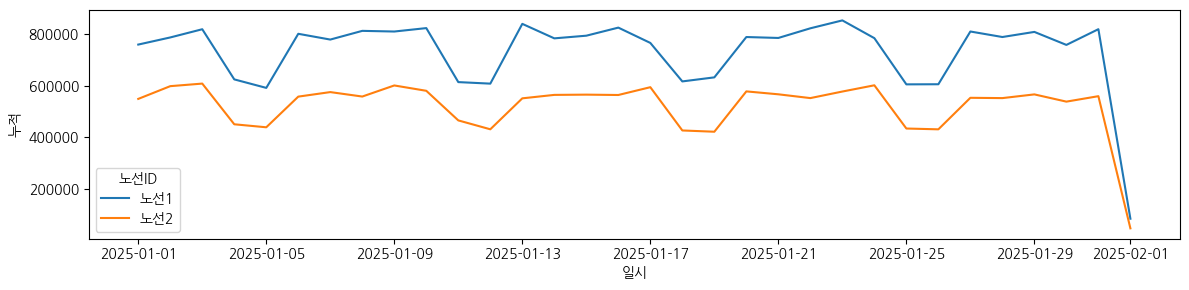

In [92]:
plot_df = pivot_df.groupby(['노선ID','일시'])[['노인','성인','청소년']].sum().reset_index()
plot_df['누적'] = plot_df[['노인','성인','청소년']].sum(axis = 1)

plot_df['일시'] = plot_df['일시'].dt.date
t = plot_df.groupby(['일시','노선ID'])['누적'].sum().reset_index()

plt.figure(figsize = (12, 3))
sns.lineplot(x = '일시', y = '누적' , hue = '노선ID', data = t)
plt.tight_layout()
plt.show()

#### ✅ 3. Model 

In [130]:
# 하차일때 마이너스(-) 기호 붙이기 
pivot.loc[pivot['행동타입'] =='하차',['노인','성인','청소년','수익']] = -pivot.loc[pivot['행동타입'] =='하차',['노인','성인','청소년','수익']]

m_df = pivot.copy()
# 1) 노인들이 가장 많이 탑승한 노선과 버스 
max_old = m_df.loc[m_df['행동타입'] == '탑승'].groupby(['노선ID','버스ID'])['노인'].max()

# 2) 노인들이 가장 적게 하차한 노선과 버스 
min_old = m_df.loc[m_df['행동타입'] == '하차'].groupby(['노선ID','버스ID'])['노인'].min()

# 3) 누적 탑승 노인 인구수 
cum_old = m_df.loc[m_df['행동타입'] == '탑승'].groupby(['노선ID','버스ID'])['노인'].sum()


In [131]:
# 4)노선ID, 버스ID 중복제거 후, 주말 여부와 시간 컬럼 생성
st = m_df[m_df['정류장ID'] ==1].drop_duplicates(['노선ID','버스ID'])[['노선ID','버스ID','일시']].reset_index(drop = True)
st['일시'] = pd.to_datetime(st['일시'])
# 출발 시간 
st['출발시간'] = st['일시'].dt.hour

# 주말 여부 
st['주말여부']= st.apply(lambda x : 1 if x['일시'].weekday() in [5,6] else 0, axis =1)
st = st.set_index(['노선ID','버스ID'])

In [132]:
# 누적 수익 
y = pivot.groupby(['노선ID','버스ID'])[['노선ID','버스ID', '수익']].tail(1).set_index(['노선ID','버스ID'])

In [138]:
model_df = pd.concat([max_old, min_old , cum_old, st, y], axis = 1).reset_index()
model_df.columns = ['노선ID','버스ID','최대탑승노인','최소탑승노인','누적노인수', '일시','출발시간','주말여부','수익']
model_df = model_df.drop(columns = ['노선ID','버스ID','일시'])
model_df.head(5)

,최대탑승노인,최소탑승노인,누적노인수,출발시간,주말여부,수익
0,5.0,0.0,12.0,21,1,0.0
1,4.0,0.0,10.0,20,1,0.0
2,11.0,0.0,43.0,8,0,0.0
3,15.0,0.0,66.0,6,0,0.0
4,8.0,0.0,34.0,12,1,0.0


In [152]:
# 15시 이전에 출발을 시작한 데이터를 train, 그 외 데이터를 test 
train_set = model_df[model_df['출발시간'] < 15]
x_train = train_set.drop(columns = ['수익'], axis = 1)
y_train = train_set['수익']


test_set = model_df[model_df['출발시간'] >= 15]
x_test = test_set.drop(columns = ['수익'], axis = 1)
y_test = test_set['수익']

print(x_train.shape , x_test.shape)

(2530, 5) (1980, 5)


In [155]:
def eval_model(name, model, x_train, x_test, y_train, y_test): 
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    mse = np.sqrt(mean_squared_error(y_test, pred))  # RMSE
    r2 = r2_score(y_test, pred)

    return mse, r2, model

res = []
model_lst = []
for name, model in [['RF', RandomForestRegressor()] , ['LR', LinearRegression()]]: 
    mse, r2, fitted_model = eval_model(name, model, x_train, x_test, y_train, y_test)
    res.append([name, mse, r2])
    model_lst.append([name, fitted_model])

result = pd.DataFrame(res, columns=['Model', 'RMSE', 'R2_score'])
print(result)

  Model  RMSE  R2_score
0    RF   0.0       1.0
1    LR   0.0       1.0


#### 🔍 통계
#### ✅  1. K개의 이항 대응 - 코크란 Q

In [181]:
df = pd.read_csv('C:/Users/82108/Notebook/EP_2_data/s1.csv')
df.head() 

,환자,치료법1,치료법2,치료법3
0,환자1,효과있음,효과없음,효과있음
1,환자2,효과없음,효과있음,효과없음
2,환자3,효과있음,효과있음,효과있음
3,환자4,효과없음,효과없음,효과없음
4,환자5,효과있음,효과있음,효과없음


In [182]:
dic = {'효과있음':1,'효과없음':0}
df['치료법1'] = df['치료법1'].map(dic)
df['치료법2'] = df['치료법2'].map(dic)
df['치료법3'] = df['치료법3'].map(dic)
df

# 대응 K - 이항 구조 - 코크란Q 
from statsmodels.stats.contingency_tables import cochrans_q 
print(cochrans_q(df.drop(columns =['환자']).values))


df          2
pvalue      1.0
statistic   0.0


#### ✅ K개의 대응 - 여러 집단의 "차이" - 프리드만 

In [184]:
df = pd.read_csv('C:/Users/82108/Notebook/EP_2_data/s2.csv')
df.head() 

,학생,학습방법A,학습방법B,학습방법C
0,학생1,30.9,37.0,72.8
1,학생2,100.0,44.6,90.6
2,학생3,53.9,15.1,82.3
3,학생4,43.0,100.0,71.9
4,학생5,22.7,58.2,100.0


In [185]:
from scipy.stats import friedmanchisquare

friedmanchisquare(df['학습방법A'],df['학습방법B'],df['학습방법C'])

FriedmanchisquareResult(statistic=np.float64(7.0), pvalue=np.float64(0.0301973834223185))